In [1]:
import numpy as np
import scipy as sp
from scipy.optimize import fsolve, minimize, root
from torch import autograd
import torch

In [2]:
####################################################################################################
## example of "backward" from https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html ##
####################################################################################################

a = torch.tensor([2.], requires_grad=True)
b = torch.tensor([4.], requires_grad=True)

obj_fun = 3*a**3 - b**3
# c_eq = 0
c_eq = a**2-b**2
# c_ineq <= 0, to be transformed into bound constraints 
c_ineq = a*b # will be a*b + y = 0, y >= 0

lm_eq = 3
lm_ineq = 1

# transform ineq constraints into eq constraints
lm_bound = 1
slack = torch.tensor([2.], requires_grad=True)
c_ineq_slack = c_ineq + slack

L = obj_fun - lm_eq*torch.cat([c_eq, c_ineq_slack]) - lm_bound*slack
# def L(x, slack): return Q(x) - lm_eq*[c_eq + c_ineq] - lm_bound*slack

external_grad = torch.tensor([1., 1.])
L.backward(gradient=external_grad)

print(a.grad)
print(b.grad)
print(slack.grad)

tensor([48.])
tensor([-78.])
tensor([-5.])


In [3]:
# objective function ()
def obj_fun(x):
    val = (x[0]**2+(x[1]-5)**2)
    return val

# constraints of form g(x) = 0
def c_eq(x):
    constr = torch.zeros(1,dtype=torch.float64)
    if constr.ndim == 0:
        constr = constr.unsqueeze(dim=0)
    return constr

# constraints of form g(x) <= 0
def c_ineq(x):
    constr = torch.cat([
        (2*x[0] + x[1] - 4).reshape(1),
        -1.*x[0].reshape(1),
        -1.*x[1].reshape(1)
    ])
    return constr

def zero_relu(x):
    res = torch.zeros_like(x)
    for i, x_elem in enumerate(x):
        res[i] = x_elem if x_elem < 0 else 0
    return res

def lagr(x, l_eq, l_ineq):
    val = obj_fun(x)
    if l_eq is not None and len(l_eq) > 0:
        eq_val = c_eq(x)
        eq_term = l_eq @ eq_val
        val -= eq_term
    if l_ineq is not None  and len(l_ineq) > 0:
        ineq_val = c_ineq(x)
        ineq_term = l_ineq @ (torch.relu((ineq_val)))
        # ineq_term = l_ineq @ zero_relu(ineq_val)
        val -= ineq_term
    return val

def lagr_univar(z, n, m_eq):
    if m_eq > 0:
        x, l_eq, l_ineq = torch.tensor_split(z, (n, n+m_eq))
    else:
        x, l_ineq = z[:n], z[n:]
        l_eq = None
    return lagr(x, l_eq, l_ineq)
    

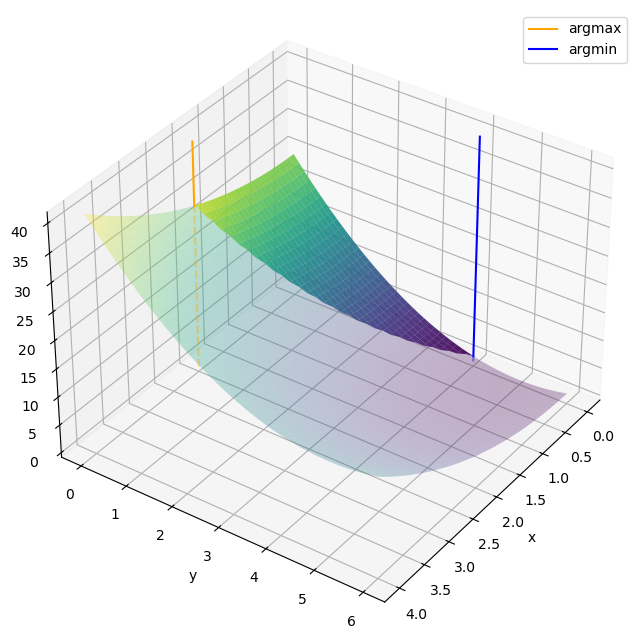

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Define grid for x and y
x = np.linspace(0, 4, 100)
y = np.linspace(0, 6, 100)
X, Y = np.meshgrid(x, y)

Z = np.array([obj_fun([x, y]) for x, y in zip(X, Y)])
constraint = -2 * X - Y + 4 >= 0

Z_masked = np.where(constraint, Z, np.nan)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_masked, cmap='viridis', edgecolor='none', alpha=0.9,zorder=-1)
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.3,zorder=-1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(35, 35, 0)
ax.plot([2, 2], [0,0], [obj_fun([2,0]), 40],zorder=10, c='orange', label='argmax')
ax.plot([2, 2], [0,0], [0, obj_fun([2,0])],zorder=10, c='orange', ls='--', alpha=0.4)
ax.plot([0, 0], [4,4], [obj_fun([0,4]), 40],zorder=10, c='blue', label='argmin')
ax.plot([0, 0], [4,4], [0, obj_fun([0,4])],zorder=10, c='blue', ls='--', alpha=0.4)

plt.legend()
plt.show()

***
Working with autograd functional api (much nicer):

In [5]:
n = 2
m_eq = 0
m_ineq = 3

In [8]:
def dl_dx(x, l, m_eq, numpy=False):
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x,dtype=torch.float64)
    if not isinstance(l, torch.Tensor):
        l = torch.tensor(l,dtype=torch.float64)
    l_eq, l_ineq = torch.tensor_split(l, [m_eq])
    jac = torch.autograd.functional.jacobian(lambda x: lagr(x,l_eq, l_ineq), x)
    if numpy:
        return jac.numpy()
    else:
        return jac
    
def dl_dlam(x, l, m_eq, numpy=False):
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x,dtype=torch.float64)
    if not isinstance(l, torch.Tensor):
        l = torch.tensor(l,dtype=torch.float64)
    l_eq, l_ineq = torch.tensor_split(l, [m_eq])
    jac = torch.autograd.functional.jacobian(lambda l_e, l_i: lagr(x,l_e, l_i), _, l_ineq)
    if numpy:
        return jac.numpy()
    else:
        return jac

In [9]:
x = torch.ones(n+m_eq+m_ineq, dtype=torch.float64)
# print(lagr_autojac_wrapper(x))
# print(lagr_autohess_wrapper(x))

dldx = dl_dx(torch.ones(n, dtype=torch.float64), torch.ones(m_eq+m_ineq, dtype=torch.float64), 0)
dldlam = dl_dlam(torch.ones(n, dtype=torch.float64), torch.ones(m_eq+m_ineq, dtype=torch.float64), 0)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [7]:
def lagr_autojac_wrapper(z, numpy=True):
    if not isinstance(z, torch.Tensor):
        z = torch.tensor(z,dtype=torch.float64)
    jac = torch.autograd.functional.jacobian(lambda x: lagr_univar(x,n, m_eq), z)
    if numpy:
        return jac.numpy()
    else:
        return jac

def lagr_autohess_wrapper(z, numpy=True):
    if not isinstance(z, torch.Tensor):
        z = torch.tensor(z,dtype=torch.float64)
    hess = torch.autograd.functional.hessian(lambda x: lagr_univar(x, n, m_eq), z)
    if numpy:
        return hess.numpy()
    else:
        return hess


x = torch.ones(n+m_eq+m_ineq, dtype=torch.float64)
print(lagr_autojac_wrapper(x))
print(lagr_autohess_wrapper(x))

[ 2. -8.  0.  0.  0.]
[[2. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


***
Try to find roots of the (auto)gradient of the lagrangian

...with scipy:

In [8]:
# find a root of gradient (jacobian) of lagrangian

sol = root(lagr_autojac_wrapper, x0=torch.zeros(n+m_ineq,dtype=torch.float64), jac=lagr_autohess_wrapper,
           method='broyden2', options={'maxiter': 5000, 'xtol':1e-12})

print(sol)
print('\n ------\n')
print(f"x = {sol['x']}")
print(f"obj. fun. at x = {obj_fun(sol['x'][:n])}")
print(f"jac. of lagr. at x = {sol['fun']}")
print(f"c_ineq at x = {c_ineq(torch.tensor(sol['x']))}")

 message: A solution was found at the specified tolerance.
 success: True
  status: 1
     fun: [ 8.937e-14  5.707e-14 -1.027e-12 -2.451e-13  0.000e+00]
       x: [-2.451e-13  4.000e+00 -2.000e+00 -4.000e+00  2.051e-01]
     nit: 15
  method: broyden2
    nfev: 57

 ------

x = [-2.45082427e-13  4.00000000e+00 -2.00000000e+00 -4.00000000e+00
  2.05128205e-01]
obj. fun. at x = 0.999999999996966
jac. of lagr. at x = [ 8.93715657e-14  5.70654635e-14 -1.02673425e-12 -2.45082427e-13
  0.00000000e+00]
c_ineq at x = tensor([ 1.0267e-12,  2.4508e-13, -4.0000e+00], dtype=torch.float64)


c:\Users\andre\miniconda3\envs\tame\lib\site-packages\scipy\optimize\_root.py:255: RuntimeWarning: Method broyden2 does not use the jacobian (jac).
  _warn_jac_unused(jac, method)
c:\Users\andre\miniconda3\envs\tame\lib\site-packages\scipy\optimize\_nonlin.py:992: RuntimeWarning: invalid value encountered in divide
  d = v / df_norm**2


...and again with scipy:

In [9]:
# find roots of gradient (jacobian) of lagrangian
from scipy.optimize import fsolve

sol = fsolve(lagr_autojac_wrapper, x0=torch.ones(n+m_eq+m_ineq,dtype=torch.float64), fprime=lagr_autohess_wrapper)
print(sol)
print(obj_fun(sol))

[-0.03467591  4.08538236 -1.82309656 -3.57243775  1.        ]
0.8377278395861524


C:\Users\andre\AppData\Local\Temp\ipykernel_13580\1552003059.py:4: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(lagr_autojac_wrapper, x0=torch.ones(n+m_eq+m_ineq,dtype=torch.float64), fprime=lagr_autohess_wrapper)


...with xitorch:

In [10]:
import xitorch
import xitorch.optimize

res = xitorch.optimize.rootfinder(lambda x: lagr_autojac_wrapper(x, numpy=False), y0=torch.zeros(n+m_ineq,dtype=torch.float64), maxiter=10000)
print(res)
print(c_ineq(res))
print(obj_fun(res))

tensor([-0.4652,  4.9296,  3.5592,  0.4255,  0.2593], dtype=torch.float64)
tensor([-7.0713e-04,  4.6516e-01, -4.9296e+00], dtype=torch.float64)
tensor(0.2213, dtype=torch.float64)


c:\Users\andre\miniconda3\envs\tame\lib\site-packages\xitorch\_impls\optimize\root\rootsolver.py:165: ConvergenceWarning: The rootfinder does not converge after 10000 iterations. Best |dx|=4.122e+00, |f|=7.007e-01 at iter 227
  warnings.warn(ConvergenceWarning(msg))


argmax is [2,0]

In [11]:
x = torch.tensor([2.,0.,2.,0.,12.])
# ineq_val = c_ineq(x)

l_ineq = x[2:]
print(lagr_autojac_wrapper(x))
torch.autograd.functional.jacobian(lambda x: torch.relu(c_ineq(x)), x)
# print(torch.autograd.functional.jacobian(lambda x: torch.relu(c_ineq(x)), x))
# print(torch.autograd.functional.jacobian(obj_fun, x))
# print(torch.autograd.functional.jacobian(lambda x: l_ineq @ zero_relu(c_ineq(x)), x))

[  4. -10.   0.   0.   0.]


tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

***
Try to use scipy.minimize with autograd jacobian and hessian (unsuccessful so far):

In [12]:
def c_ineq_eq(x):
    constr = torch.cat([
        (2*x[0] + x[1] - 4).reshape(1),
        -1*x[0].reshape(1),
        -1*x[1].reshape(1)
    ])
    return torch.max(torch.zeros_like(constr,dtype=torch.float64), constr)

In [11]:
def constr_autojac(x):
    return torch.autograd.functional.jacobian(c_ineq_eq, torch.tensor(x,dtype=torch.float64),create_graph=True).numpy()

def constr_autohess(x, v):
    return torch.autograd.functional.hessian(lambda x: c_ineq_eq(x) @ torch.tensor(v,dtype=torch.float64), torch.tensor(x,dtype=torch.float64)).numpy()

print(constr_autojac([1.,1.,1.]))
print(constr_autohess([1.,1.,1.], [1.,1.,1.]))

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [12]:
from scipy.optimize import NonlinearConstraint

x0=torch.zeros(n,dtype=torch.float64)

c = NonlinearConstraint(lambda x: c_ineq_eq(torch.tensor(x)), lb=torch.tensor([4.,0.,0.]), ub=torch.tensor([4.,0.,0.]), jac=constr_autojac, hess=constr_autohess)

# res = minimize(obj_fun, x0=x0, jac=lambda x: torch.tensor([2.*x[0], 2.*x[1]-10.]), constraints=[c],method='SLSQP')


res = minimize(obj_fun, x0=x0, jac=lambda x: torch.tensor([2.*x[0], 2.*x[1]-10.]),
               constraints=[{'type':'eq','fun':lambda x: c_ineq_eq(torch.tensor(x)),'jac':constr_autojac}],method='trust-constr')

res

ValueError: The 'expected square matrix' error can occur if there are more equality constraints than independent variables. Consider how your constraints are set up, or use factorization_method='SVDFactorization'.